## Iterative design

The tissue cartography process involves multiple steps:

1. create a segmentation of your 3d data

2. convert the segmentation into a mesh of your surface of interest

3. load the mesh into blender to map to unwrap it into the plane

4. make a cartographic projection of your the 3d data using the unwrapped mesh

It is likely that after your first pass, you will not be 100% satified with the results, and in general, you will need to iterate steps 1-4 to achieve good results. A key advantage of using blender is that you can visualize your results from the previous pass and use them as guide. Here we will see how to improve an initial unwwapping/cartographic projection of an examle dataset of the zebrafish egg.

Crucially, almost _any_ unwrapping map will give you good-enough results to visualize the data on the blender 3d model. You can then use that as a guide to make a better unwrapping.

In [1]:
from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import interpolation as tcinterp

In [2]:
import numpy as np
from skimage import transform
from scipy import stats, spatial, linalg
import matplotlib.pyplot as plt
import os

## Load dataset

This dataset is a lightsheet recording of the early zebrafish embryo right before epiboly, showing fluorescent nuclei. Courtesy of S. Wopat, Streichan lab UCSB.

In [3]:
metadata_dict = {"filename": "fish_example/zebrafish_egg_nuclei",
                 "resolution_in_microns": [1.662, 1.662, 1.662]}

In [4]:
image = tcio.adjust_axis_order(tcio.imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (1, 246, 194, 248)


In [5]:
# segmentation and meshing are already done for this dataset
mesh = tcmesh.ObjMesh.read_obj(f"{metadata_dict['filename']}.obj")

In [6]:
slice_image, slice_vertices = tcinterp.get_cross_section_vertices_normals(
    1, 80, image, mesh, metadata_dict["resolution_in_microns"], width=2, get_normals=False)

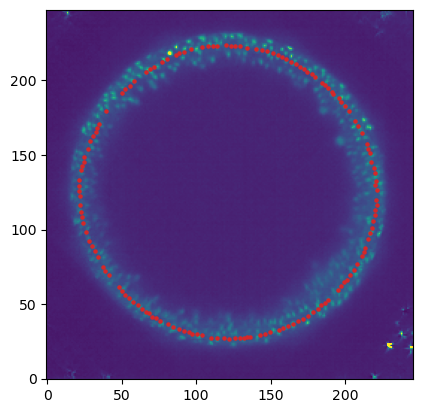

In [7]:
plt.scatter(*slice_vertices.T, s=5, c="tab:red")

plt.imshow(slice_image[0], vmax=10000, origin="lower")

## Unwrapping in blender

Let's unwrap our mesh in blender. Open a new blender project, and import `zebrafish_egg_nuclei.obj`. We'll start by using a standar-issue spherical projection for unwrapping. In the UV Editor, look at the egg "from above", and choose "UV->Sphere project" with "View on poles":

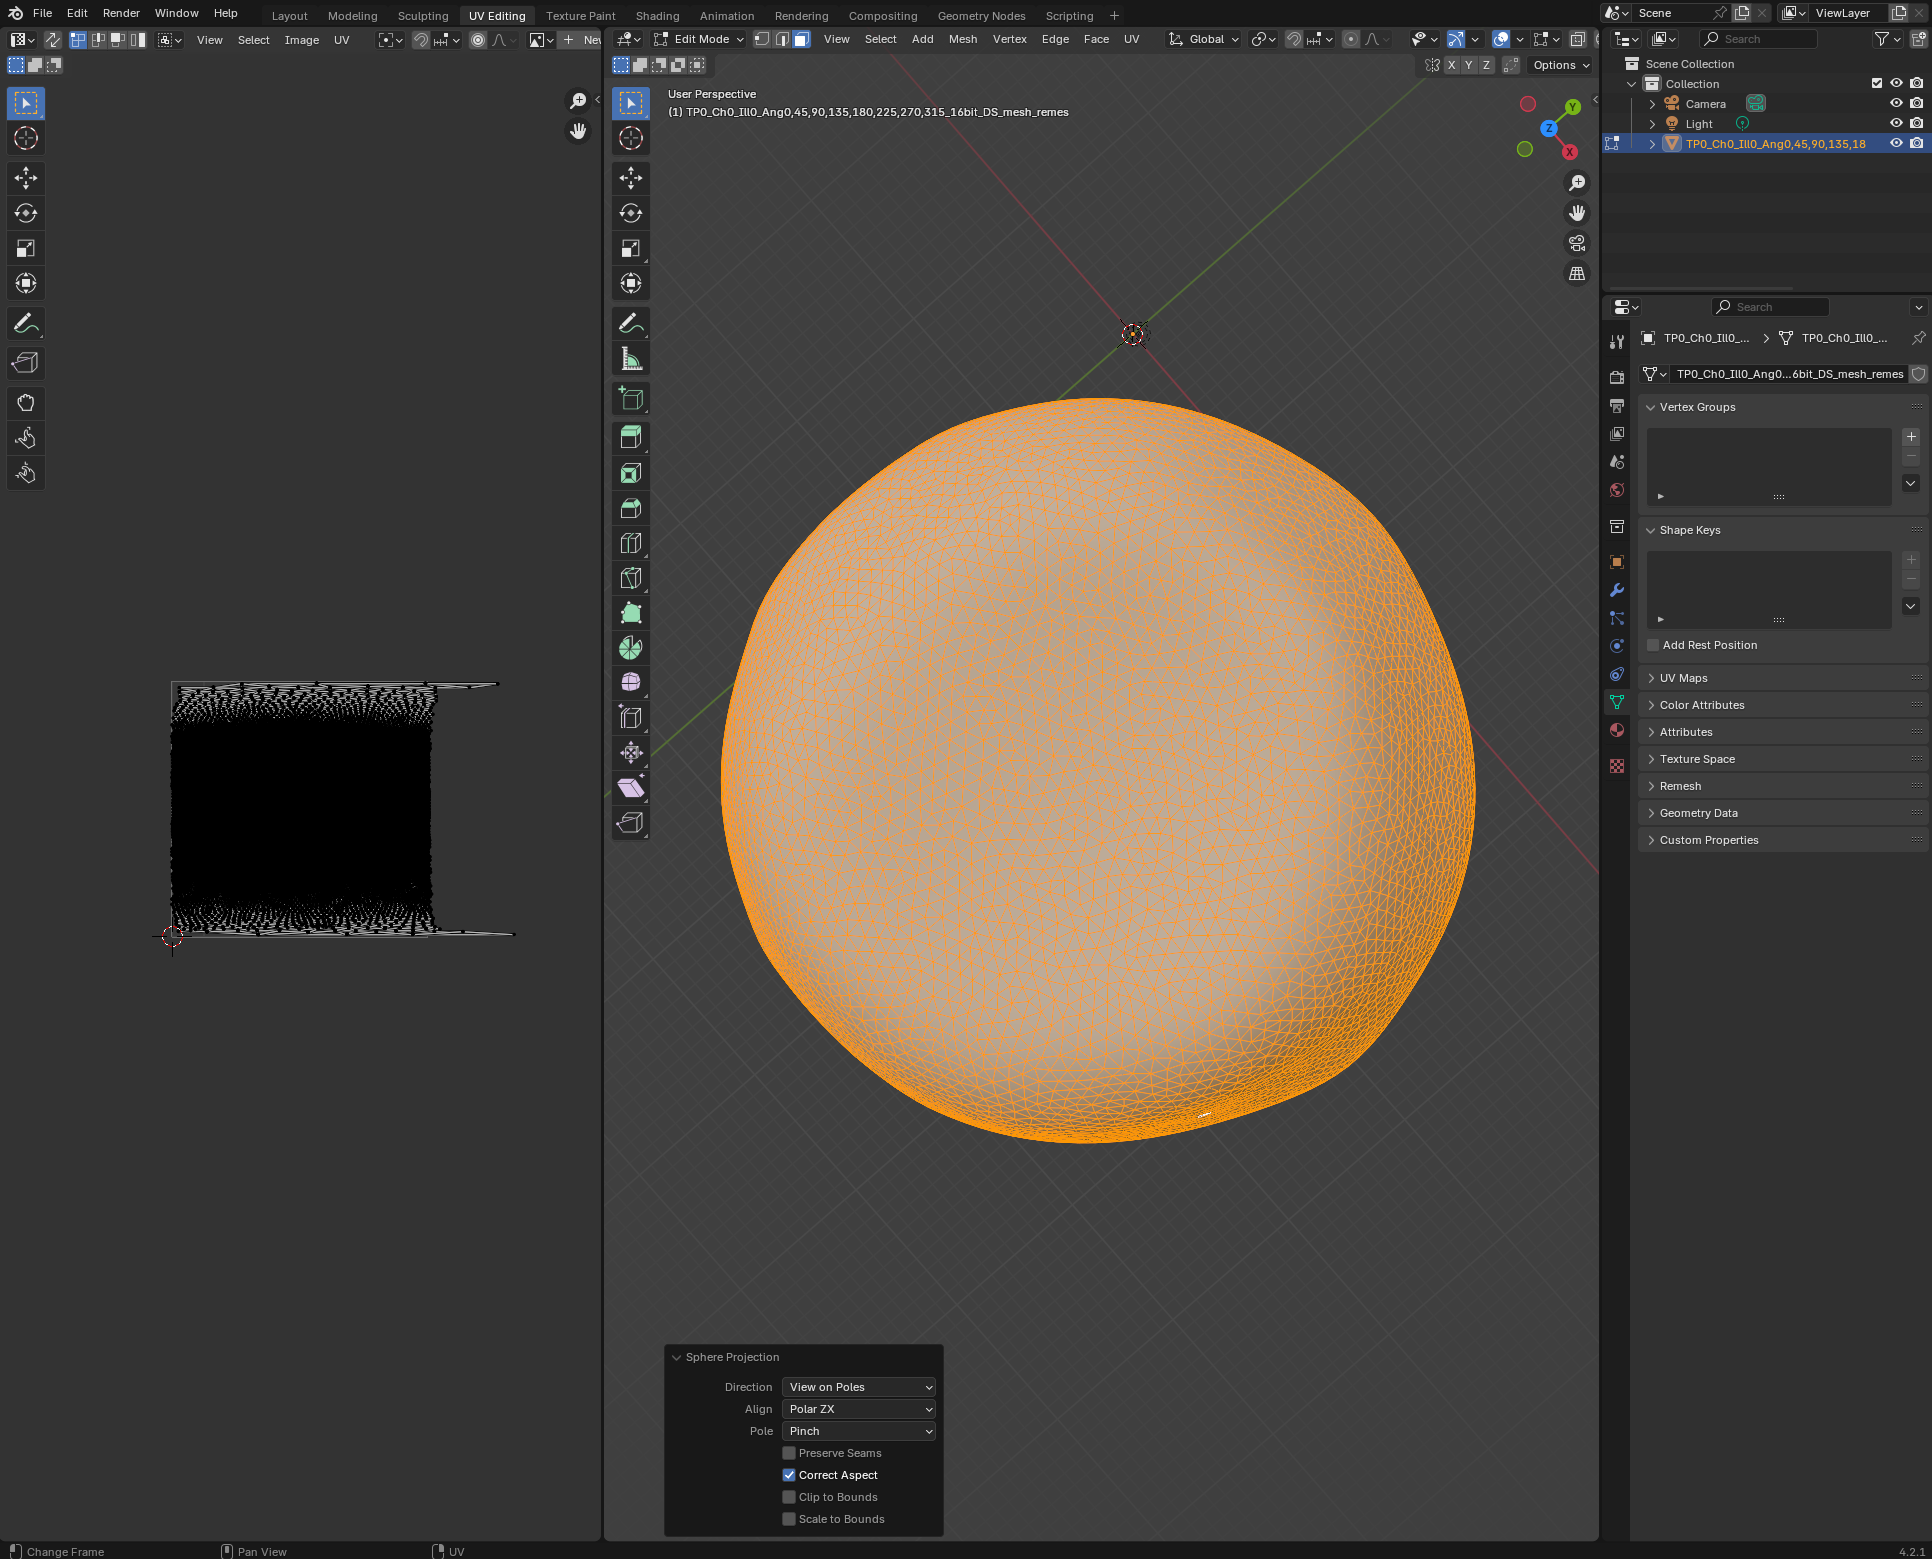

Export the result as `zebrafish_egg_nuclei_uv_first_iteration.obj`.

## First iteration: Cartographic projection

Let's use this "automatic" UV projection to get the 3d data as texture on our mesh. With that as guidance, we can then refine our UV projection.

In [8]:
normal_offsets = np.array([-4, -2, 0, 2, 4])
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [11]:
projected_data, projected_coordinates, projected_normals = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"fish_example/zebrafish_egg_nuclei_uv_first_iteration.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps,
    use_fallback=True)
# for the initial UV map, we use the fallback option since there are a lot of flipped triangles which
# can mess up our cartographic interpolation

/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/interpolation.py:215: RuntimeWarning: UV map has self-intersections, 20185 flipped triangles. Try use_fallback=True?
  warnings.warn("UV map has self-intersections, {} flipped triangles. Try use_fallback=True?".format(


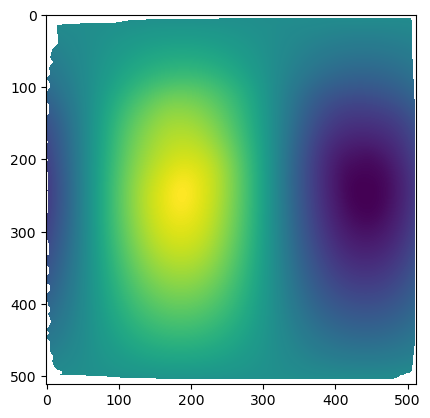

In [12]:
plt.imshow(projected_coordinates[...,0])

The projected data has a lot of distortion, and shows a large part of the embryo we don't care about - the dark part on the top, which is just yolk.

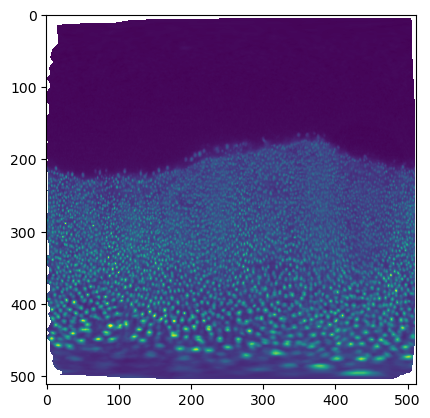

In [13]:
plt.imshow(projected_data[0, 0], vmax=10000)


In [37]:
# save images for visualization in blender
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
tcio.save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))

## Second iteration

Let's go back to blender and, in the Shading workspace, add our projected images as textures on the 3d mesh:

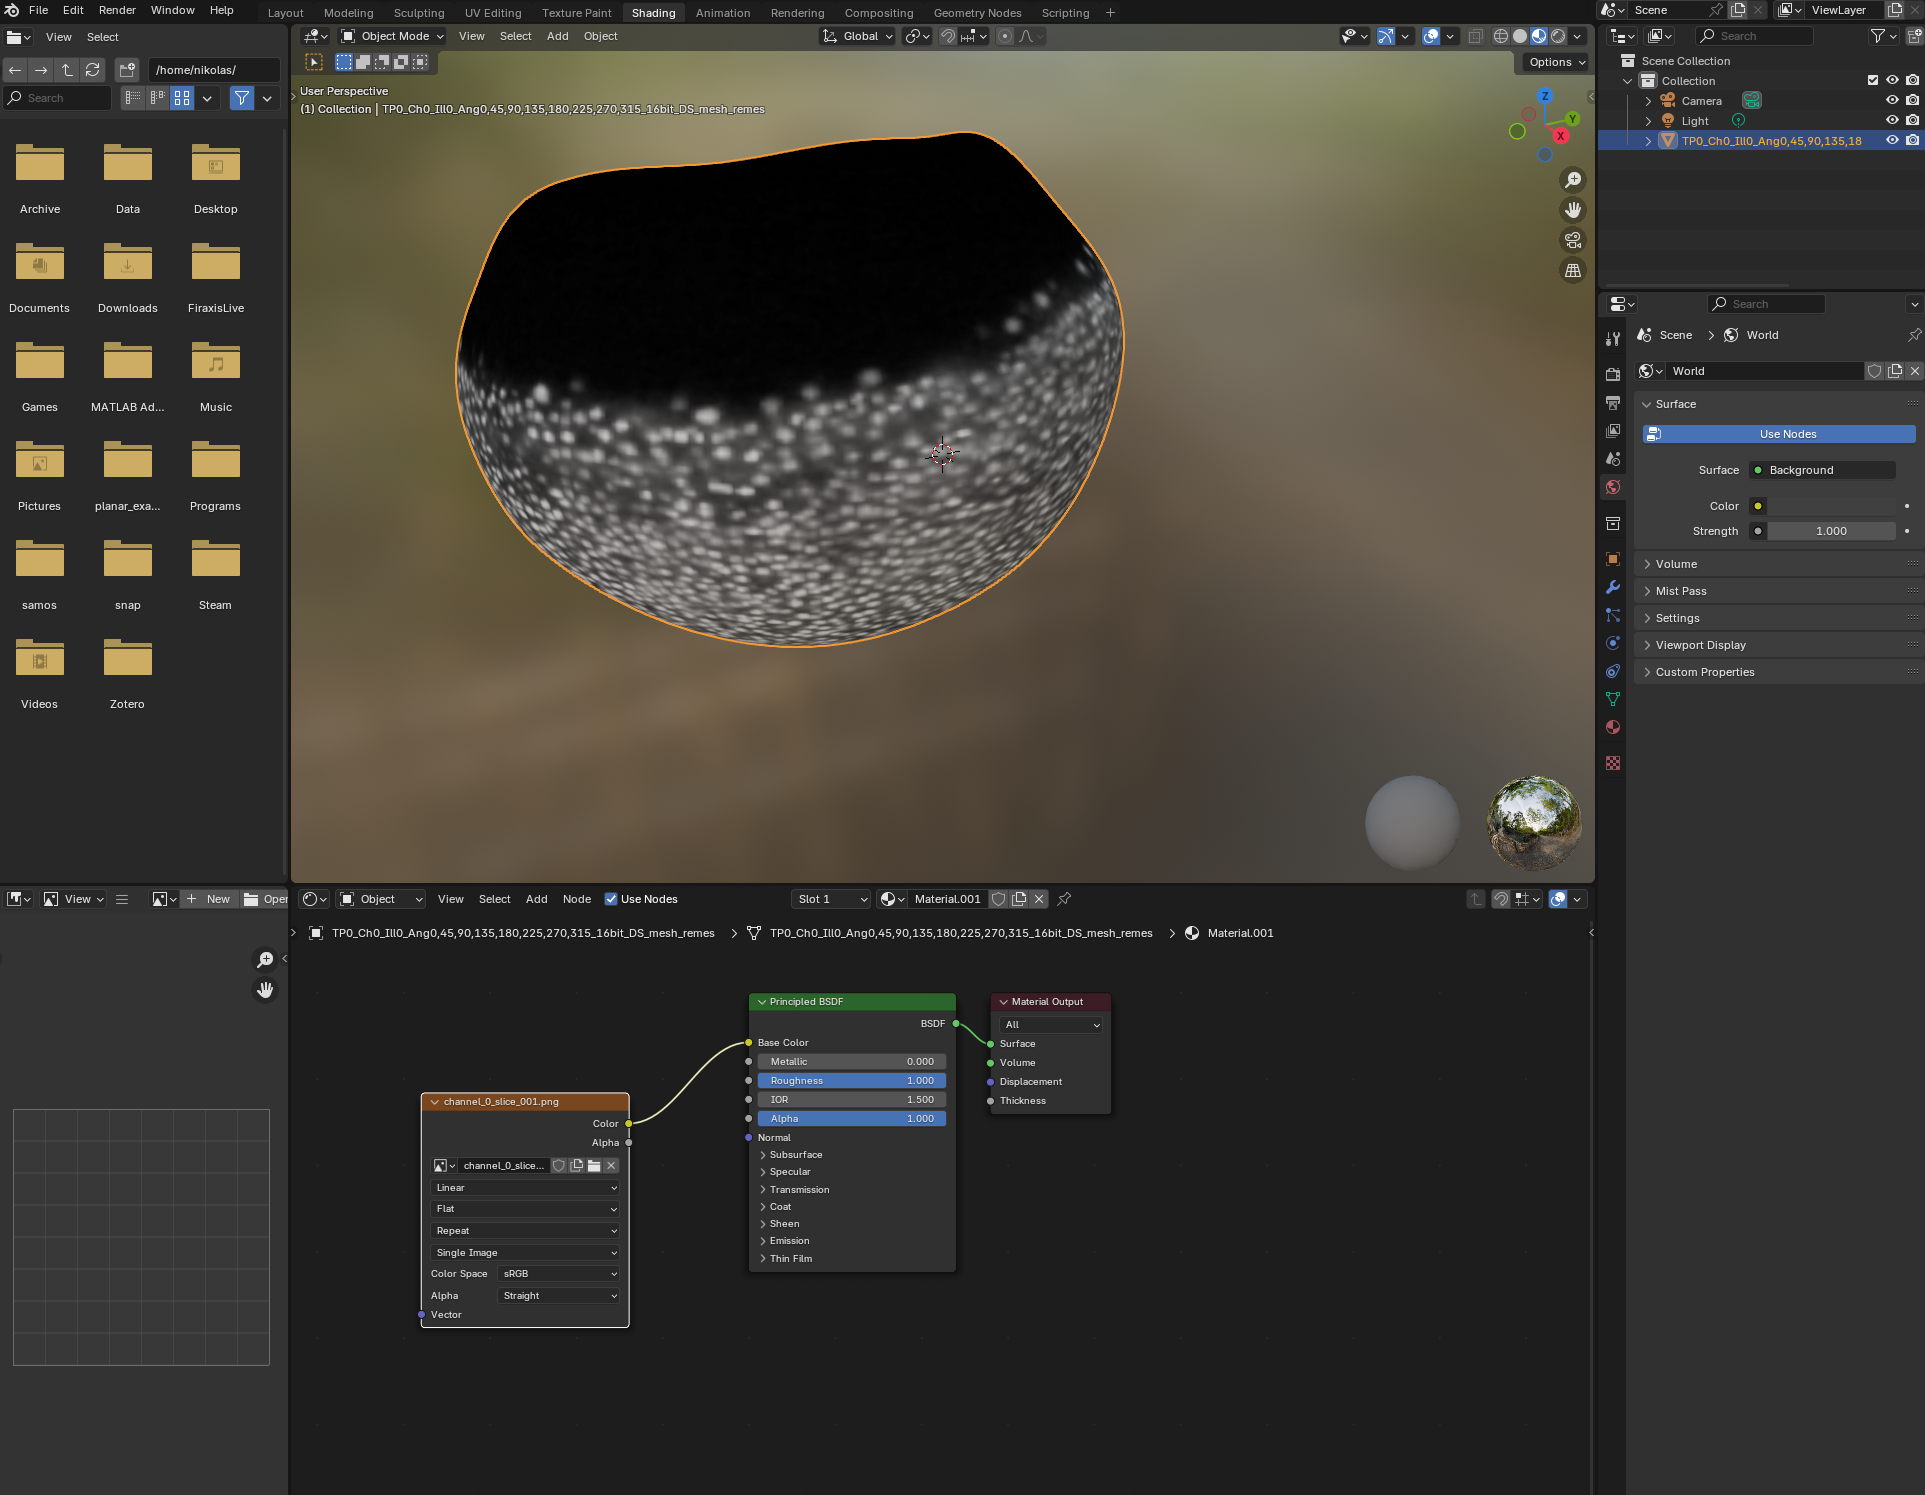

Now we can see what part of the embryo we care about! Let's go back to the UV Editor workspace, and make a seam along the edge of the region where there are cells. To do so, we want to use "Material preview" as Viewport shading:

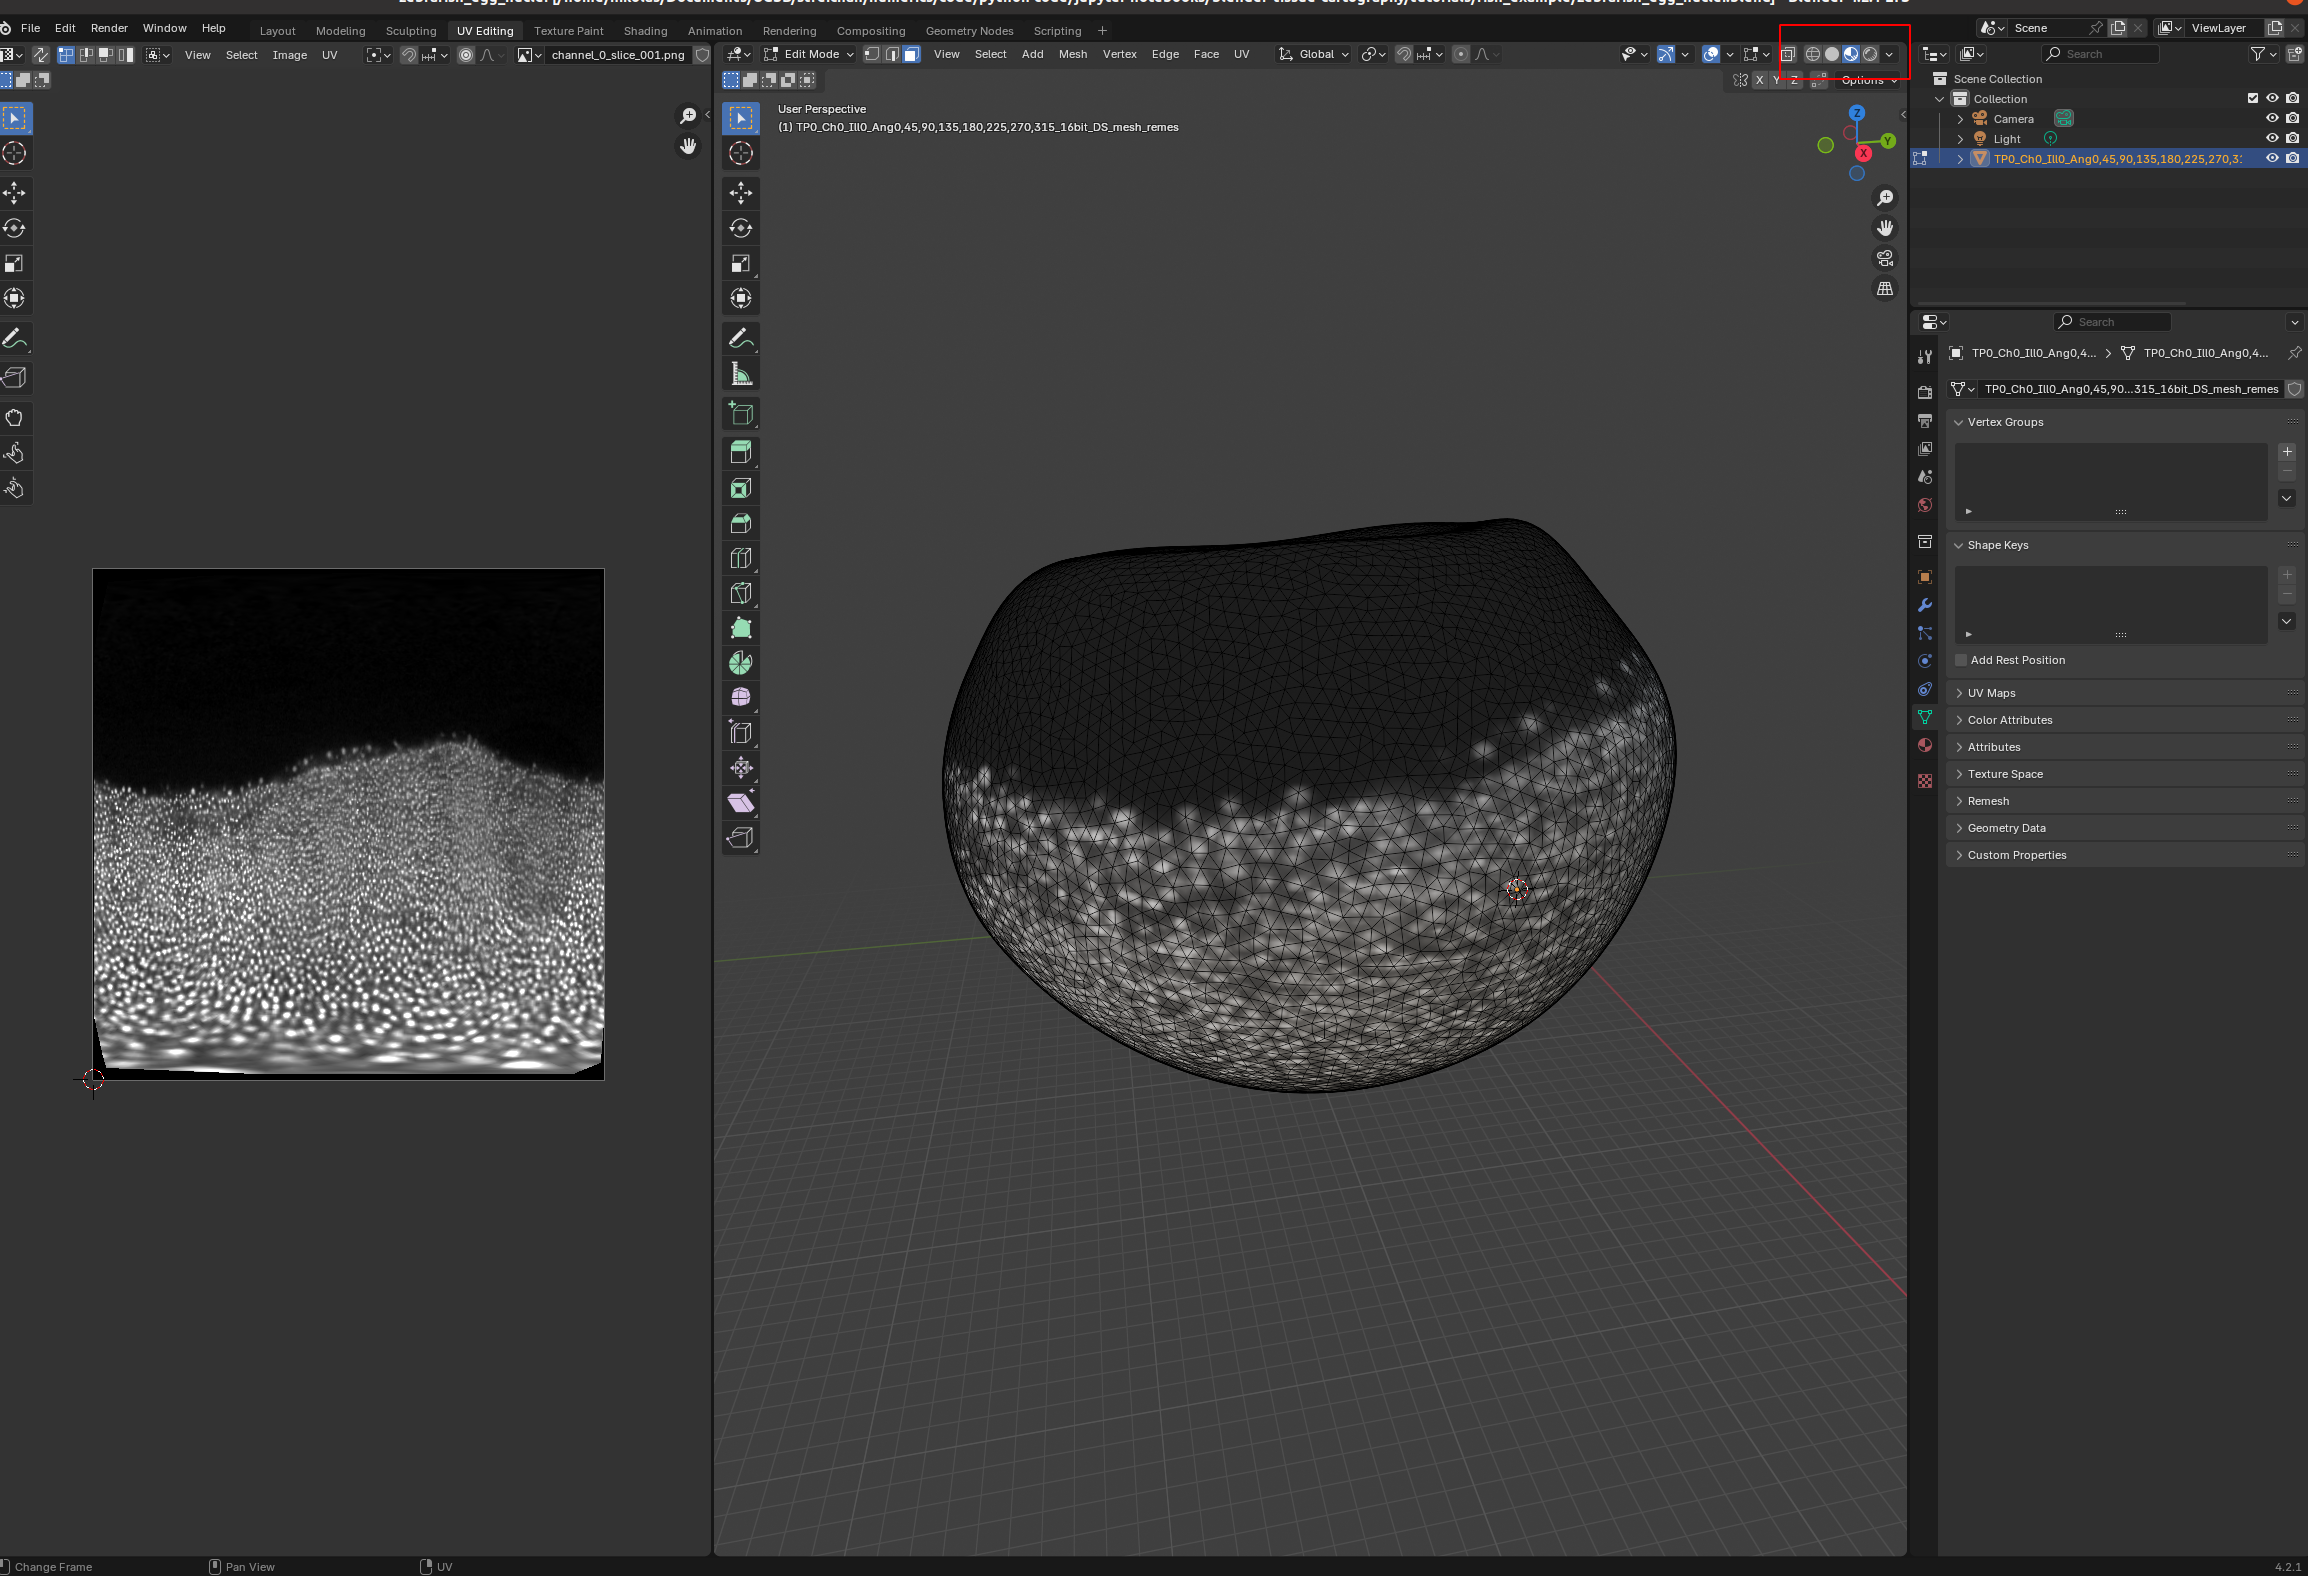

Now we can choose a nice seam. Let's use "circle select" ("C") and select the top part of the mesh:

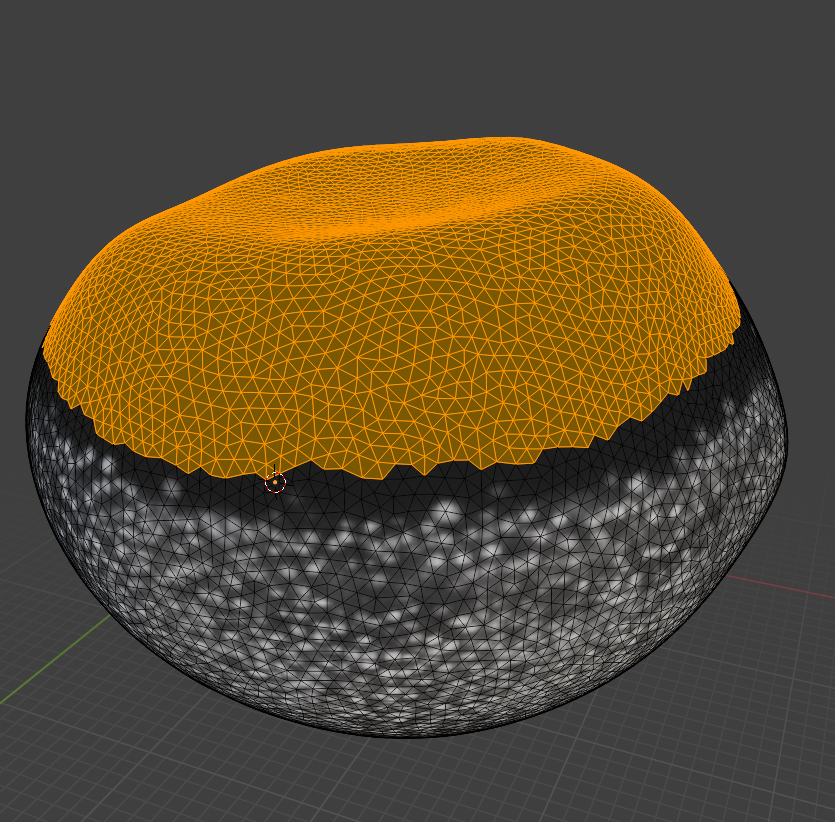

and then get the boundary loop by "Select -> Select loops -> Select boundary loop". Right click and "Mark as seam":

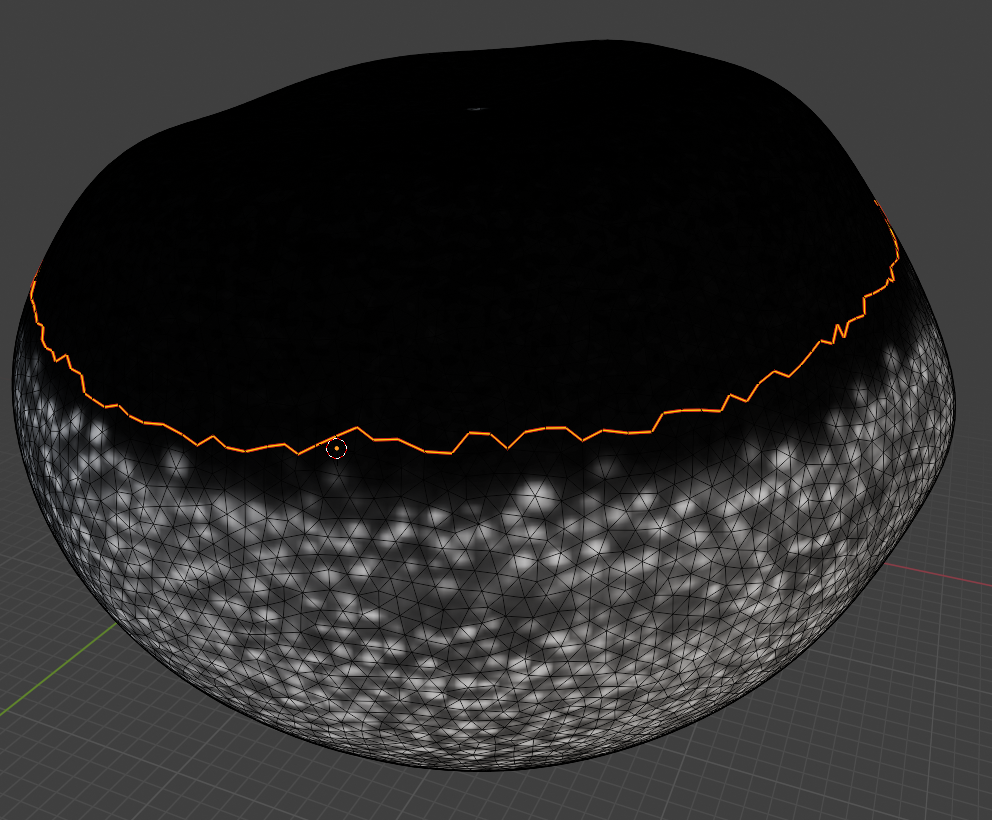

Now we have a seam that matches well the region we care about! Let's use UV unwrapping to generate a new UV map:

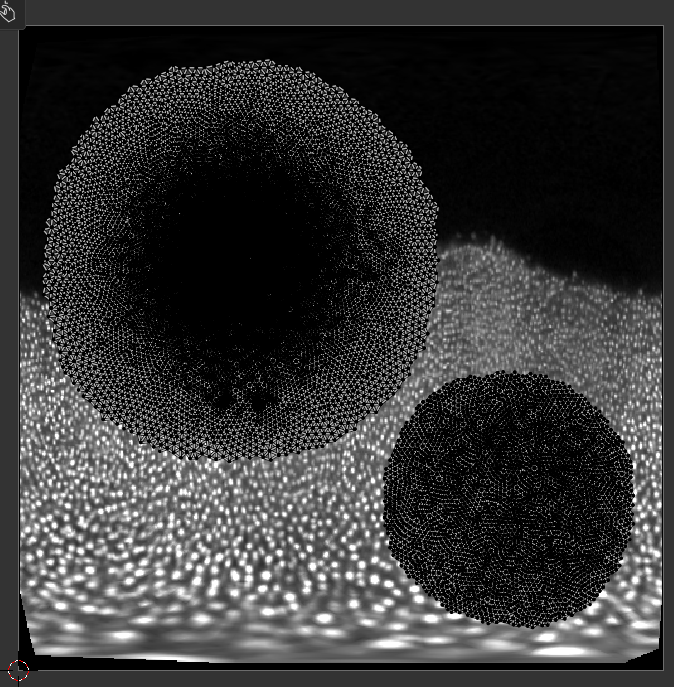

The projected data is now a bunch better - the region of interest has much less distortion. You can make the uninteresing "top" part of the mesh very small, and scale the main part of the UV map to better fill the UV square, using the scaling tool.

Click on the patch ("island"), press "L" to select the whole patch, and "S" for scale and "G" for translate. Click to confirm.

### Second iteration: cartographic projection

Let's export the mesh as `zebrafish_egg_nuclei_uv_second_iteration.obj` and create a new cartogrpahic projection!

In [14]:
normal_offsets = np.array([-4, -2, 0, 2, 4])
metadata_dict["normal_offsets"] = normal_offsets # add the info to the metadata
uv_grid_steps = 512

In [15]:
projected_data, projected_coordinates, projected_normals = tcinterp.create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"fish_example/zebrafish_egg_nuclei_uv_second_iteration.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)


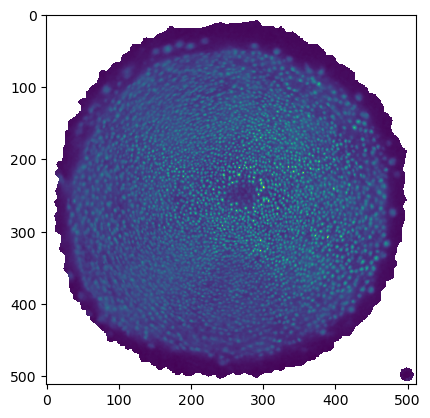

In [16]:
plt.imshow(projected_data[0, 0], vmax=10000)


In [49]:
# save images for visualization in blender
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures_second_iteration"
tcio.save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))

Visualized in blender:
   
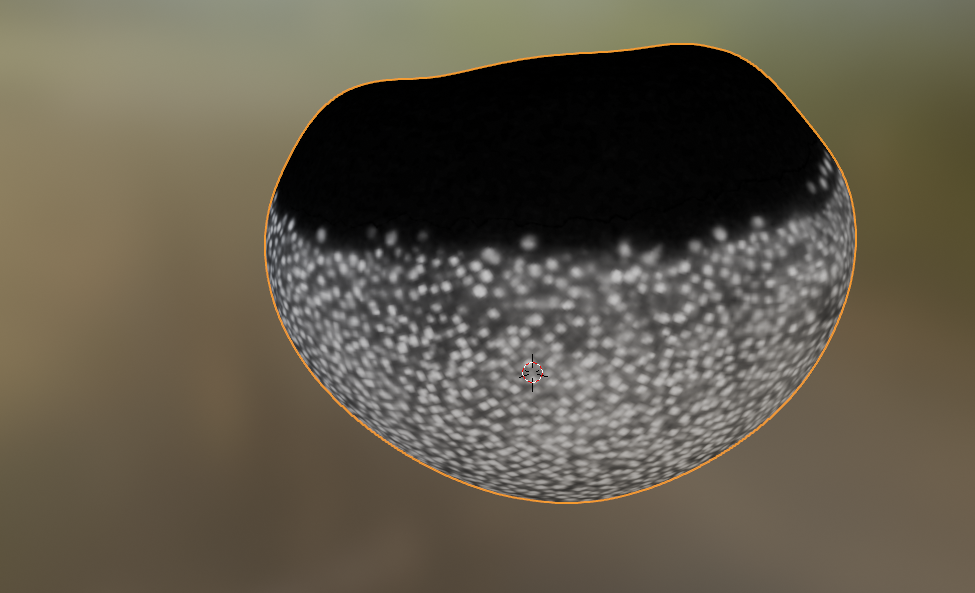